# NB 04: Module-Level Analysis

Test whether ICA fitness modules responding to field-relevant conditions
are more conserved (higher core gene fraction) than modules responding
to lab-only conditions.

Analyses:
1. Module conservation score (fraction of member genes that are core)
2. Module ecological relevance (mean activity across field vs lab conditions)
3. Correlation: `module_core_fraction ~ module_field_activity`
4. Module characterization: ecological vs lab modules
5. Gene-level candidates from ecological modules

**Run locally** — uses cached data from upstream projects + NB02 output.

**Outputs**: 2 figures in `figures/`, module characterization table.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['savefig.bbox'] = 'tight'

DATA_DIR = Path('../data')
FIG_DIR = Path('../figures')
FIG_DIR.mkdir(exist_ok=True)

## 1. Load Data

In [2]:
# Module membership: gene x module binary matrix
membership = pd.read_csv(
    '../../fitness_modules/data/modules/DvH_gene_membership.csv',
    index_col=0
)
print(f"Module membership: {membership.shape[0]} genes x {membership.shape[1]} modules")

# Module-condition activity scores
mod_cond = pd.read_csv(
    '../../fitness_modules/data/modules/DvH_module_conditions.csv'
)
print(f"Module-condition activity: {len(mod_cond)} rows")
print(f"  Modules: {mod_cond['module'].nunique()}")
print(f"  Experiments: {mod_cond['expName'].nunique()}")

# Module annotations (functional enrichments)
mod_annot = pd.read_csv(
    '../../fitness_modules/data/modules/DvH_module_annotations.csv'
)
print(f"Module annotations: {len(mod_annot)} rows")

# Experiment classification from NB02
exp_class = pd.read_csv(DATA_DIR / 'experiment_classification.csv')
print(f"Experiment classification: {len(exp_class)} experiments")

# Pangenome link (DvH only)
link = pd.read_csv(
    '../../conservation_vs_fitness/data/fb_pangenome_link.tsv',
    sep='\t'
)
link_dvh = link[link['orgId'] == 'DvH'].copy()
link_dvh['locusId'] = link_dvh['locusId'].astype(int)
print(f"Pangenome link (DvH): {len(link_dvh)} genes")

# SEED annotations
seed = pd.read_csv(
    '../../conservation_vs_fitness/data/seed_annotations.tsv',
    sep='\t', dtype={'gene': str}
)
seed_dvh = seed[seed['orgId'] == 'DvH'].copy()
print(f"SEED annotations (DvH): {len(seed_dvh)} genes")

Module membership: 2741 genes x 52 modules
Module-condition activity: 260 rows
  Modules: 52
  Experiments: 198
Module annotations: 140 rows
Experiment classification: 757 experiments


Pangenome link (DvH): 3206 genes
SEED annotations (DvH): 2815 genes


## 2. Module Conservation Score

For each of 52 modules, compute fraction of member genes that are core.

In [3]:
# Build gene -> is_core mapping
# Handle string 'True'/'False' or actual bools
is_core_raw = link_dvh.set_index('locusId')['is_core']
if is_core_raw.dtype == object:
    gene_core = is_core_raw.map({'True': True, 'False': False}).to_dict()
else:
    gene_core = is_core_raw.fillna(False).astype(bool).to_dict()

# For each module, compute conservation
module_stats = []
modules = membership.columns.tolist()

for mod in modules:
    member_genes = membership.index[membership[mod] == 1].tolist()
    n_members = len(member_genes)
    if n_members == 0:
        continue
    
    # Count core genes
    n_core = sum(1 for g in member_genes if gene_core.get(g, False))
    n_with_link = sum(1 for g in member_genes if g in gene_core)
    
    module_stats.append({
        'module': mod,
        'n_members': n_members,
        'n_with_link': n_with_link,
        'n_core': n_core,
        'core_fraction': n_core / n_with_link if n_with_link > 0 else np.nan
    })

mod_stats = pd.DataFrame(module_stats)
print(f"Module conservation scores: {len(mod_stats)} modules")
print(f"  Mean core fraction: {mod_stats['core_fraction'].mean():.3f}")
print(f"  Median core fraction: {mod_stats['core_fraction'].median():.3f}")
print(f"  Range: {mod_stats['core_fraction'].min():.3f} - {mod_stats['core_fraction'].max():.3f}")
mod_stats.head(10)

Module conservation scores: 52 modules
  Mean core fraction: 0.886
  Median core fraction: 1.000
  Range: 0.000 - 1.000


,module,n_members,n_with_link,n_core,core_fraction
0,M000,8,8,6,0.750000
1,M001,3,3,3,1.000000
2,M002,19,19,19,1.000000
3,M003,9,9,7,0.777778
4,M004,9,9,8,0.888889
5,M005,12,12,10,0.833333
6,M006,15,15,14,0.933333
7,M007,17,17,8,0.470588
8,M008,7,7,7,1.000000
9,M009,4,4,4,1.000000


## 3. Module Ecological Relevance

For each module, compute mean absolute activity across field vs lab conditions.

In [4]:
# Map experiments to broad categories
exp_to_cat = exp_class.set_index('expName')['category'].to_dict()
exp_to_broad = exp_class.set_index('expName')['broad_category'].to_dict()

# Add category to module-condition table
mod_cond['category'] = mod_cond['expName'].map(exp_to_cat)
mod_cond['broad_category'] = mod_cond['expName'].map(exp_to_broad)

print("Module-condition activity by broad category:")
print(mod_cond.groupby('broad_category')['abs_activity'].agg(['mean', 'count']))

Module-condition activity by broad category:
                    mean  count
broad_category                 
field           0.240946    131
lab             0.231699    129


In [5]:
# Compute mean absolute activity per module per broad category
mod_activity = mod_cond.groupby(['module', 'broad_category'])['abs_activity'].mean().unstack(fill_value=0)
mod_activity.columns = [f'mean_activity_{c}' for c in mod_activity.columns]
mod_activity = mod_activity.reset_index()

# Also compute per fine category
mod_activity_fine = mod_cond.groupby(['module', 'category'])['abs_activity'].mean().unstack(fill_value=0)
mod_activity_fine = mod_activity_fine.reset_index()

print(f"Module activity (broad): {mod_activity.shape}")
print(f"Module activity (fine): {mod_activity_fine.shape}")

# Merge with conservation stats
mod_combined = mod_stats.merge(mod_activity, on='module', how='left')
mod_combined = mod_combined.merge(mod_activity_fine, on='module', how='left', suffixes=('', '_fine'))

# Compute field/lab activity ratio
if 'mean_activity_field' in mod_combined.columns and 'mean_activity_lab' in mod_combined.columns:
    mod_combined['field_lab_ratio'] = (
        mod_combined['mean_activity_field'] /
        mod_combined['mean_activity_lab'].replace(0, np.nan)
    )

print(f"\nCombined module table: {len(mod_combined)} modules")
mod_combined[['module', 'n_members', 'core_fraction',
              'mean_activity_field', 'mean_activity_lab']].head(10)

Module activity (broad): (52, 3)
Module activity (fine): (52, 7)

Combined module table: 52 modules


,module,n_members,core_fraction,mean_activity_field,mean_activity_lab
0,M000,8,0.750000,0.208600,0.000000
1,M001,3,1.000000,0.208901,0.000000
2,M002,19,1.000000,0.000000,0.150004
3,M003,9,0.777778,0.139379,0.123832
4,M004,9,0.888889,0.000000,0.290945
5,M005,12,0.833333,0.000000,0.299652
6,M006,15,0.933333,0.000000,0.321461
7,M007,17,0.470588,0.000000,0.165578
8,M008,7,1.000000,0.288439,0.143942
9,M009,4,1.000000,0.000000,0.179172


## 4. Correlation: Module Conservation vs Field Activity

In [6]:
# Test correlation
valid = mod_combined.dropna(subset=['core_fraction', 'mean_activity_field'])

if len(valid) > 5:
    r_field, p_field = stats.spearmanr(valid['core_fraction'], valid['mean_activity_field'])
    r_lab, p_lab = stats.spearmanr(valid['core_fraction'], valid['mean_activity_lab'])
    
    print("Spearman correlation (module core fraction vs activity):")
    print(f"  Field activity: rho={r_field:.3f}, p={p_field:.4g}")
    print(f"  Lab activity:   rho={r_lab:.3f}, p={p_lab:.4g}")
    
    if 'field_lab_ratio' in valid.columns:
        valid_ratio = valid.dropna(subset=['field_lab_ratio'])
        r_ratio, p_ratio = stats.spearmanr(valid_ratio['core_fraction'],
                                           valid_ratio['field_lab_ratio'])
        print(f"  Field/Lab ratio: rho={r_ratio:.3f}, p={p_ratio:.4g}")
else:
    print("Not enough modules for correlation analysis")

Spearman correlation (module core fraction vs activity):
  Field activity: rho=0.071, p=0.6152
  Lab activity:   rho=0.041, p=0.7719
  Field/Lab ratio: rho=-0.139, p=0.4203


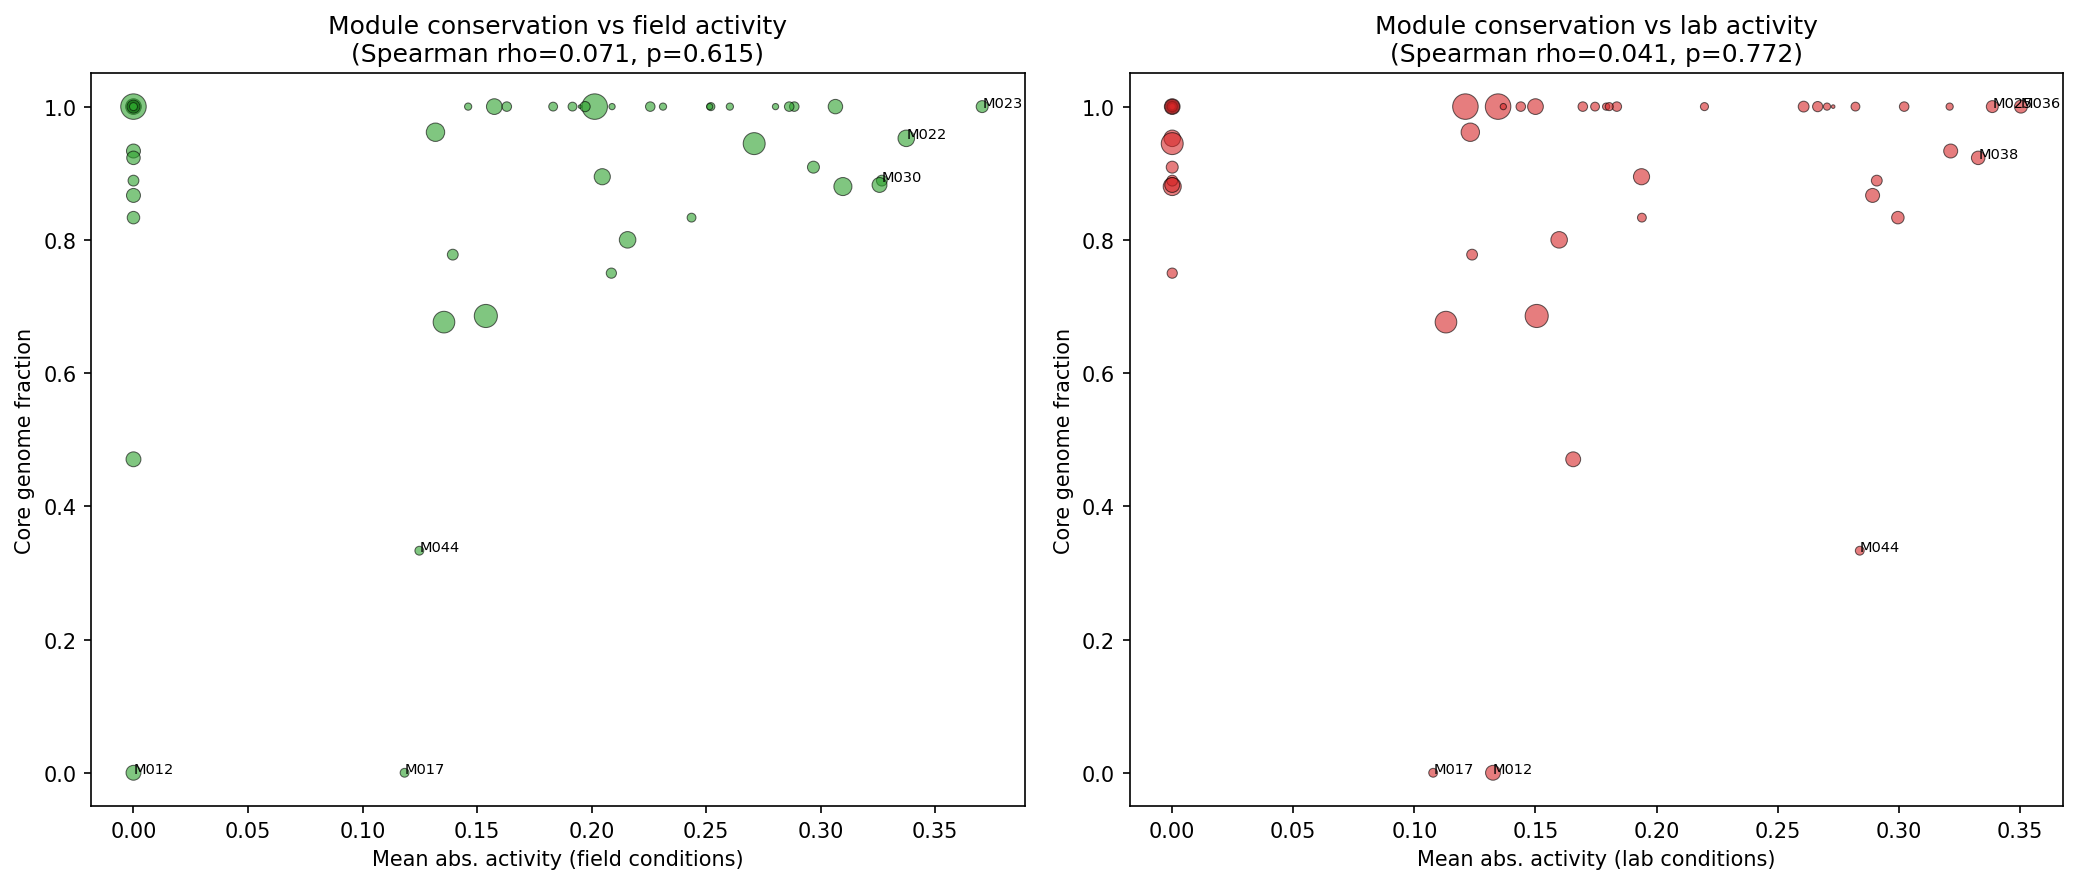

In [7]:
# Figure 1: Scatter of module core fraction vs field condition activity
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel A: Field activity vs conservation
ax = axes[0]
ax.scatter(valid['mean_activity_field'], valid['core_fraction'],
           s=valid['n_members'] * 3, alpha=0.6, edgecolor='black', linewidth=0.5,
           c='#2ca02c')

# Add labels for extreme modules
for _, row in valid.nlargest(3, 'mean_activity_field').iterrows():
    ax.annotate(row['module'], (row['mean_activity_field'], row['core_fraction']),
                fontsize=7, ha='left')
for _, row in valid.nsmallest(3, 'core_fraction').iterrows():
    ax.annotate(row['module'], (row['mean_activity_field'], row['core_fraction']),
                fontsize=7, ha='left')

ax.set_xlabel('Mean abs. activity (field conditions)')
ax.set_ylabel('Core genome fraction')
ax.set_title(f'Module conservation vs field activity\n'
             f'(Spearman rho={r_field:.3f}, p={p_field:.3g})')
ax.set_ylim(-0.05, 1.05)

# Panel B: Lab activity vs conservation
ax = axes[1]
ax.scatter(valid['mean_activity_lab'], valid['core_fraction'],
           s=valid['n_members'] * 3, alpha=0.6, edgecolor='black', linewidth=0.5,
           c='#d62728')

for _, row in valid.nlargest(3, 'mean_activity_lab').iterrows():
    ax.annotate(row['module'], (row['mean_activity_lab'], row['core_fraction']),
                fontsize=7, ha='left')
for _, row in valid.nsmallest(3, 'core_fraction').iterrows():
    ax.annotate(row['module'], (row['mean_activity_lab'], row['core_fraction']),
                fontsize=7, ha='left')

ax.set_xlabel('Mean abs. activity (lab conditions)')
ax.set_ylabel('Core genome fraction')
ax.set_title(f'Module conservation vs lab activity\n'
             f'(Spearman rho={r_lab:.3f}, p={p_lab:.3g})')
ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.savefig(FIG_DIR / 'fig_module_conservation_vs_activity.png')
plt.show()

## 5. Ecological vs Lab Module Characterization

Classify modules as "ecological" (field-active + highly conserved) vs
"lab" (lab-active + less conserved).

In [8]:
# Classify modules
# Use mean instead of median for core_fraction threshold, because
# median=1.0 would prevent any module from being classified as "ecological"
median_field = mod_combined['mean_activity_field'].median()
mean_core = mod_combined['core_fraction'].mean()

print(f"Classification thresholds:")
print(f"  Field activity > median = {median_field:.4f}")
print(f"  Core fraction > mean = {mean_core:.3f} (median was {mod_combined['core_fraction'].median():.3f})")
print()

def classify_module(row):
    high_field = row['mean_activity_field'] > median_field
    high_core = row['core_fraction'] > mean_core
    
    if high_field and high_core:
        return 'ecological'
    elif not high_field and not high_core:
        return 'lab'
    elif high_field and not high_core:
        return 'field-variable'
    else:
        return 'conserved-quiet'

mod_combined['module_type'] = mod_combined.apply(classify_module, axis=1)

print("Module classification:")
print(mod_combined['module_type'].value_counts())

Classification thresholds:
  Field activity > median = 0.1731
  Core fraction > mean = 0.886 (median was 1.000)

Module classification:
module_type
ecological         21
conserved-quiet    17
lab                 9
field-variable      5
Name: count, dtype: int64


In [9]:
# Add functional annotations for each module
# Get top annotation per module (lowest FDR)
sig_annot = mod_annot[mod_annot['significant'] == True].copy()
if len(sig_annot) > 0:
    top_annot = sig_annot.sort_values('fdr').groupby('module').first().reset_index()
    top_annot = top_annot[['module', 'term', 'database', 'odds_ratio', 'fdr']]
    top_annot.columns = ['module', 'top_term', 'top_db', 'top_or', 'top_fdr']
    
    mod_combined = mod_combined.merge(top_annot, on='module', how='left')

# Show ecological modules
print("Ecological modules (field-active + conserved):")
eco_mods = mod_combined[mod_combined['module_type'] == 'ecological']
display_cols = ['module', 'n_members', 'core_fraction',
                'mean_activity_field', 'mean_activity_lab']
if 'top_term' in mod_combined.columns:
    display_cols += ['top_term', 'top_db']
eco_mods[display_cols].sort_values('mean_activity_field', ascending=False)

Ecological modules (field-active + conserved):


,module,n_members,core_fraction,mean_activity_field,mean_activity_lab,top_term,top_db
23,M023,11,1.000000,0.370467,0.000000,Phosphonate ABC transporter phosphate-binding ...,SEED
22,M022,21,0.952381,0.337329,0.000000,PF04879,PFam
30,M030,9,0.888889,0.326659,0.000000,FIG00603085: hypothetical protein,SEED
51,M051,16,1.000000,0.306403,0.000000,PF13533,PFam
28,M028,11,0.909091,0.296810,0.000000,PF00037,PFam
8,M008,7,1.000000,0.288439,0.143942,PF12679,PFam
32,M032,7,1.000000,0.286228,0.000000,K10040,KEGG
43,M043,3,1.000000,0.280256,0.000000,NaN,NaN
35,M035,37,0.944444,0.270945,0.000000,FIG00603085: hypothetical protein,SEED
40,M040,4,1.000000,0.260326,0.000000,K00532,KEGG


In [10]:
# Show lab modules
print("Lab modules (lab-biased + less conserved):")
lab_mods = mod_combined[mod_combined['module_type'] == 'lab']
lab_mods[display_cols].sort_values('mean_activity_lab', ascending=False)

Lab modules (lab-biased + less conserved):


,module,n_members,core_fraction,mean_activity_field,mean_activity_lab,top_term,top_db
5,M005,12,0.833333,0.000000,0.299652,NaN,NaN
34,M034,15,0.866667,0.000000,0.289211,PF00528,PFam
44,M044,6,0.333333,0.124774,0.283917,PF13641,PFam
7,M007,17,0.470588,0.000000,0.165578,PF13186,PFam
20,M020,41,0.685714,0.153807,0.150508,K02003,KEGG
12,M012,17,0.000000,0.000000,0.132460,TIGR01539,TIGRFam
3,M003,9,0.777778,0.139379,0.123832,PF00072,PFam
31,M031,36,0.676471,0.135532,0.113038,NaN,NaN
17,M017,6,0.000000,0.118333,0.107751,NaN,NaN


/tmp/ipykernel_31185/1059578287.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=plot_types, patch_artist=True)


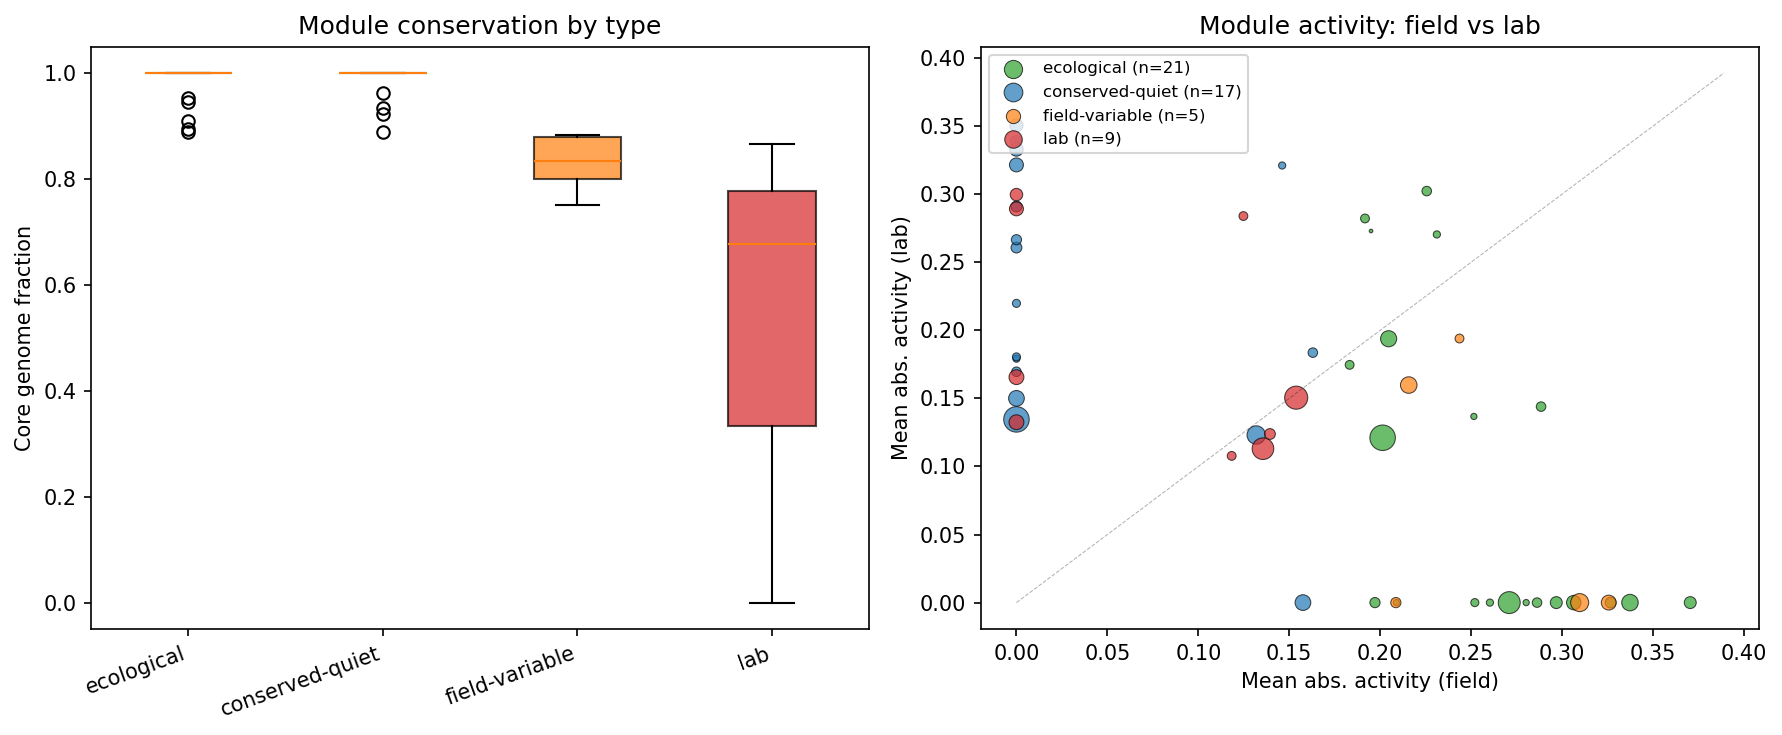

In [11]:
# Figure 2: Comparison of ecological vs lab module profiles
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Panel A: Core fraction by module type
ax = axes[0]
type_order = ['ecological', 'conserved-quiet', 'field-variable', 'lab']
type_colors = {'ecological': '#2ca02c', 'conserved-quiet': '#1f77b4',
               'field-variable': '#ff7f0e', 'lab': '#d62728'}

plot_types = [t for t in type_order if t in mod_combined['module_type'].values]
box_data = [mod_combined[mod_combined['module_type'] == t]['core_fraction'].values
            for t in plot_types]

bp = ax.boxplot(box_data, labels=plot_types, patch_artist=True)
for patch, t in zip(bp['boxes'], plot_types):
    patch.set_facecolor(type_colors.get(t, '#7f7f7f'))
    patch.set_alpha(0.7)

ax.set_ylabel('Core genome fraction')
ax.set_title('Module conservation by type')
ax.set_xticklabels(plot_types, rotation=20, ha='right')

# Panel B: Field vs lab activity colored by module type
ax = axes[1]
for t in type_order:
    subset = mod_combined[mod_combined['module_type'] == t]
    if len(subset) == 0:
        continue
    ax.scatter(subset['mean_activity_field'], subset['mean_activity_lab'],
               c=type_colors.get(t, '#7f7f7f'), label=f'{t} (n={len(subset)})',
               s=subset['n_members'] * 3, alpha=0.7, edgecolor='black', linewidth=0.5)

# Diagonal
lim = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.plot([0, lim], [0, lim], 'k--', linewidth=0.5, alpha=0.3)

ax.set_xlabel('Mean abs. activity (field)')
ax.set_ylabel('Mean abs. activity (lab)')
ax.set_title('Module activity: field vs lab')
ax.legend(fontsize=8, loc='upper left')

plt.tight_layout()
plt.savefig(FIG_DIR / 'fig_ecological_vs_lab_modules.png')
plt.show()

## 6. Gene-Level Candidates from Ecological Modules

Genes in ecological modules that lack annotation are candidates for
novel environmental adaptation functions.

In [12]:
# Get genes from ecological modules
eco_module_names = eco_mods['module'].tolist()

eco_genes = []
for mod in eco_module_names:
    if mod not in membership.columns:
        continue
    member_genes = membership.index[membership[mod] == 1].tolist()
    for g in member_genes:
        eco_genes.append({'locusId': int(g), 'module': mod})

eco_gene_df = pd.DataFrame(eco_genes)
print(f"Genes in ecological modules: {len(eco_gene_df)}")

if len(eco_gene_df) > 0:
    # Merge with SEED annotations
    seed_cols = seed_dvh.columns.tolist()
    desc_col = 'seed_desc' if 'seed_desc' in seed_cols else 'description' if 'description' in seed_cols else None
    
    if desc_col and 'locusId' in seed_cols:
        seed_dvh_subset = seed_dvh[['locusId', desc_col]].copy()
        seed_dvh_subset['locusId'] = seed_dvh_subset['locusId'].astype(int)
        eco_gene_df = eco_gene_df.merge(seed_dvh_subset, on='locusId', how='left')
    
    # Merge with conservation
    core_map = link_dvh[['locusId', 'is_core']].copy()
    if core_map['is_core'].dtype == object:
        core_map['is_core'] = core_map['is_core'].map({'True': True, 'False': False}).astype(bool)
    else:
        core_map['is_core'] = core_map['is_core'].fillna(False).astype(bool)
    eco_gene_df = eco_gene_df.merge(core_map, on='locusId', how='left')
    
    # Identify unannotated genes
    if desc_col and desc_col in eco_gene_df.columns:
        unannotated = eco_gene_df[
            eco_gene_df[desc_col].isna() |
            eco_gene_df[desc_col].str.contains('hypothetical|uncharacterized', case=False, na=True)
        ]
        print(f"Unannotated genes in ecological modules: {len(unannotated)}")
        print(f"  Of which core: {unannotated['is_core'].sum()}")
        print()
        print("These are candidates for novel environmental adaptation functions.")
        unannotated.head(20)
    else:
        print("SEED annotation column not found; showing all ecological genes.")
        eco_gene_df.head(20)
else:
    print("No ecological modules found (none had both high field activity and high conservation).")
    print("This may indicate that conservation and field activity are not strongly correlated at the module level.")
    unannotated = pd.DataFrame()

Genes in ecological modules: 239
Unannotated genes in ecological modules: 52
  Of which core: 44

These are candidates for novel environmental adaptation functions.


## 7. Summary

In [13]:
print("=" * 60)
print("MODULE-LEVEL ANALYSIS SUMMARY")
print("=" * 60)
print()
print(f"Modules analyzed: {len(mod_combined)}")
print(f"  Mean core fraction: {mod_combined['core_fraction'].mean():.3f}")
print(f"  Median core fraction: {mod_combined['core_fraction'].median():.3f}")
print()
print("Module classification:")
for t in ['ecological', 'conserved-quiet', 'field-variable', 'lab']:
    n = (mod_combined['module_type'] == t).sum()
    if n > 0:
        cf = mod_combined[mod_combined['module_type'] == t]['core_fraction'].mean()
        print(f"  {t:20s}: {n:3d} modules, mean core fraction = {cf:.3f}")
print()
print("Correlations (Spearman):")
try:
    print(f"  Core fraction vs field activity: rho={r_field:.3f}, p={p_field:.4g}")
    print(f"  Core fraction vs lab activity:   rho={r_lab:.3f}, p={p_lab:.4g}")
except NameError:
    print("  (correlation variables not computed)")
print()
print(f"Genes in ecological modules: {len(eco_gene_df)}")
if 'unannotated' in dir() and len(unannotated) > 0:
    print(f"  Unannotated candidates: {len(unannotated)}")
print("=" * 60)

MODULE-LEVEL ANALYSIS SUMMARY

Modules analyzed: 52
  Mean core fraction: 0.886
  Median core fraction: 1.000

Module classification:
  ecological          :  21 modules, mean core fraction = 0.980
  conserved-quiet     :  17 modules, mean core fraction = 0.983
  field-variable      :   5 modules, mean core fraction = 0.829
  lab                 :   9 modules, mean core fraction = 0.516

Correlations (Spearman):
  Core fraction vs field activity: rho=0.071, p=0.6152
  Core fraction vs lab activity:   rho=0.041, p=0.7719

Genes in ecological modules: 239
  Unannotated candidates: 52


In [14]:
# Save module characterization table
mod_combined.to_csv(DATA_DIR / 'module_characterization.csv', index=False)
print(f"Saved: {DATA_DIR / 'module_characterization.csv'}")

Saved: ../data/module_characterization.csv
